In [11]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from sklearn.manifold import TSNE
from pprint import pprint
import urllib.request
import random
import re
import torch._dynamo
import os
from torch.optim.lr_scheduler import StepLR

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


/home/venkat/anaconda3/lib/python3.12/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1728945370933/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [13]:
url = "https://www.gutenberg.org/files/1661/1661-0.txt"
response = urllib.request.urlopen(url)
sherlock_text = response.read().decode("utf-8")
sherlock_text = sherlock_text[1504:]

In [14]:
def generate_word_prediction_dataset(text, block_size=5, print_limit=20):
    """
    Generates a dataset for word-based prediction from input text.
    
    Args:
        text (str): Input text to process.
        block_size (int): Number of words used as context to predict the next word.
        print_limit (int): Number of (context, target) pairs to print for visualization.

    Returns:
        X (torch.Tensor): Input tensor containing contexts.
        Y (torch.Tensor): Output tensor containing target word indices.
        stoi (dict): String-to-index mapping of words.
        itos (dict): Index-to-string mapping of words.
    """
    # Step 1: Split the text into sentences using regex
    sentences = re.split(r'\.\s+|\r\n\r\n', text)

    # Step 2: Clean each sentence and tokenize into words
    cleaned_sentences = [
        re.sub(r'[^a-zA-Z0-9 ]', ' ', sentence) 
        for sentence in sentences
    ]

    # **Filter out sentences with fewer than two words**
    cleaned_sentences = [s for s in cleaned_sentences if len(s.split()) >= 2]

    words = [word for sentence in cleaned_sentences for word in sentence.split()]

    # Step 3: Create vocabulary and mappings
    vocabulary = set(words)
    
    stoi = {word: i + 1 for i, word in enumerate(vocabulary)}
    stoi["."] = 0  # Sentence-end marker
    itos = {i: word for word, i in stoi.items()}
    itos[0] = "."  # Ensure "." is included in `itos`

    X, Y = [], []  # Inputs and targets
    count = 0  # Counter for visualization

    # Step 4: Generate (X, Y) pairs using a sliding window over sentences
    for sentence in cleaned_sentences:
        sentence_words = sentence.split()  # Tokenize sentence into words

        # Initialize context with zeros (padding)
        context = [0] * block_size  
        for word in sentence_words + ['.']:  # Include "." as sentence-end marker
            ix = stoi[word]  # Get index of the current word
            X.append(context)  # Add current context to inputs
            Y.append(ix)  # Add target word index to outputs

            # Print context-target pairs (limited by `print_limit`)
            if count < print_limit:
                print(' '.join(itos[i] for i in context), '--->', itos[ix])
                count += 1

            # Slide the context window by one word
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    print(f"Dataset generated with {len(X)} samples")
    return X, Y, stoi, itos

    print(f"Dataset generated with {len(X)} samples")
    return X, Y, stoi, itos
X, Y, stoi, itos = generate_word_prediction_dataset(sherlock_text, block_size=5, print_limit=20)

. . . . . ---> A
. . . . A ---> SCANDAL
. . . A SCANDAL ---> IN
. . A SCANDAL IN ---> BOHEMIA
. A SCANDAL IN BOHEMIA ---> .
. . . . . ---> To
. . . . To ---> Sherlock
. . . To Sherlock ---> Holmes
. . To Sherlock Holmes ---> she
. To Sherlock Holmes she ---> is
To Sherlock Holmes she is ---> always
Sherlock Holmes she is always ---> the
Holmes she is always the ---> woman
she is always the woman ---> .
. . . . . ---> I
. . . . I ---> have
. . . I have ---> seldom
. . I have seldom ---> heard
. I have seldom heard ---> himmention
I have seldom heard himmention ---> her
Dataset generated with 106890 samples


In [15]:
print("X tensor shape:", X.shape)
print("y tensor shape:", Y.shape)


X tensor shape: torch.Size([106890, 5])
y tensor shape: torch.Size([106890])


10251

In [47]:
class NextWord(nn.Module):
    
    def __init__(self, block_size, vocab_size, emb_dim, hidden_size, activation_fn='ReLU'):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lin1 = nn.Linear(block_size * emb_dim, hidden_size)
        self.lin2 = nn.Linear(hidden_size, vocab_size)
        if activation_fn == 'ReLU':
            self.activation = nn.ReLU()
        elif activation_fn == 'Tanh':
            self.activation = nn.Tanh()
        else:
            raise ValueError("Unsupported activation function. Use 'relu' or 'tanh'.")

    def forward(self, x):
        x = self.emb(x)
        x = x.view(x.shape[0], -1)
        x = self.activation(self.lin1(x))  # Apply activation function
        x = self.lin2(x)
        return x


In [48]:
def save_model(model, embedding_size, context_length, activation_fn):
    # Create a name based on parameters
    model_name = f"model_emb{embedding_size}_ctx{context_length}_act{activation_fn}.pth"
    
    # Save the model state dictionary
    torch.save(model.state_dict(), model_name)
    print(f"Model saved as {model_name}")


In [49]:
def generate_text(model, itos, stoi, block_size, input_sentence, max_len=100):
    # Convert the input sentence to a list of word indices
    input_indices = [stoi.get(word, 0) for word in input_sentence.split()]  # 0 for unknown words
    
    # Initialize context with the last `block_size` indices of the input sentence
    context = [0] * max(0, block_size - len(input_indices)) + input_indices[-block_size:]
    generated_text = input_sentence.strip() + ' '
    
    for _ in range(max_len):
        x = torch.tensor(context).view(1, -1).to(device)
        y_pred = model(x)
        
        # Sample the next word
        ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()
        next_word = itos[ix]
        
        # Append the generated word to the text
        generated_text += next_word + ' '
        
        # Update the context
        context = context[1:] + [ix]
    
    # Remove spaces before periods
    generated_text = generated_text.replace(' .', '.')
    
    return generated_text.strip()

In [50]:
os.environ["PYTORCH_ENABLE_TRITON"] = "0"
torch._dynamo.config.suppress_errors = True
# torch._dynamo.config.verbose=True

loss_fn = nn.CrossEntropyLoss()

hidden_size = 1024
batch_size = 4096
print_every =50
num_epochs = 500

for emb_dim in [64]:
    for block_size in [5, 10, 15]:
        for activation_function in ["ReLU", "Tanh"]:
            X_tensor, y_tensor, stoi, itos = generate_word_prediction_dataset(sherlock_text, block_size = block_size, print_limit = 10)
            model = NextWord(block_size, len(stoi), emb_dim, hidden_size, activation_function).to(device)
            
            opt = torch.optim.AdamW(model.parameters(), lr=0.01)
            scheduler = StepLR(opt, step_size=50, gamma=0.1)
            X_tensor.to(device)
            y_tensor.to(device)
            for epoch in range(num_epochs):
                for i in range(0, X_tensor.shape[0], batch_size):
                    x = X_tensor[i:i + batch_size].to(device)
                    y = y_tensor[i:i + batch_size].to(device)
                    y_pred = model(x)
                    loss = loss_fn(y_pred, y)
                    loss.backward()
                    opt.step()
                    opt.zero_grad()
                scheduler.step()
                if (epoch+1) % print_every == 0:
                    print(f"Epoch: {epoch+1}, Loss: {loss.item()}")
            save_model(model, emb_dim, block_size, activation_function)
           

. . . . . ---> A
. . . . A ---> SCANDAL
. . . A SCANDAL ---> IN
. . A SCANDAL IN ---> BOHEMIA
. A SCANDAL IN BOHEMIA ---> .
. . . . . ---> To
. . . . To ---> Sherlock
. . . To Sherlock ---> Holmes
. . To Sherlock Holmes ---> she
. To Sherlock Holmes she ---> is
Dataset generated with 106890 samples
Epoch: 50, Loss: 0.4175814390182495
Epoch: 100, Loss: 0.3982818126678467
Epoch: 150, Loss: 0.39578843116760254
Epoch: 200, Loss: 0.39560261368751526
Epoch: 250, Loss: 0.39558807015419006
Epoch: 300, Loss: 0.3955872058868408
Epoch: 350, Loss: 0.3955869972705841
Epoch: 400, Loss: 0.3955869972705841
Epoch: 450, Loss: 0.3955869972705841
Epoch: 500, Loss: 0.3955869972705841
Model saved as model_emb64_ctx5_actReLU.pth
. . . . . ---> A
. . . . A ---> SCANDAL
. . . A SCANDAL ---> IN
. . A SCANDAL IN ---> BOHEMIA
. A SCANDAL IN BOHEMIA ---> .
. . . . . ---> To
. . . . To ---> Sherlock
. . . To Sherlock ---> Holmes
. . To Sherlock Holmes ---> she
. To Sherlock Holmes she ---> is
Dataset generated with

In [51]:
# Generate sample words
input = "Hi"
print(generate_text(model, itos, stoi, block_size,input, 1000))


Hi Ha And the flap has been gummed if I am not verymuch in error by a person who had been chewing tobacco. companion large number fortunes year out of the stranger and you have us for it still St.. every twelve and lay little those fromthe make behind him to in the door of the attendant. hurried to be seen hardly works to go who has at the good but by Sherlock and I the window with the states have not am... of any Cooee of the letter of the eyes.. than the other of the Project in as a learn very Mr. to come of our dear work.. must lot you for my days and I shall sure Briony a child between the best which and my seven what up. into the light of the strange to London. at the jewelcase of the electronic. the brought into the son she had the way in Mr. states. and request to hear we her arms this best about a said he. in his from.. and I am no one of one who was to me. circumstances we may not be. again the life. bit were love.. asthe commonly them change so. they can. Miss Stoner well or 

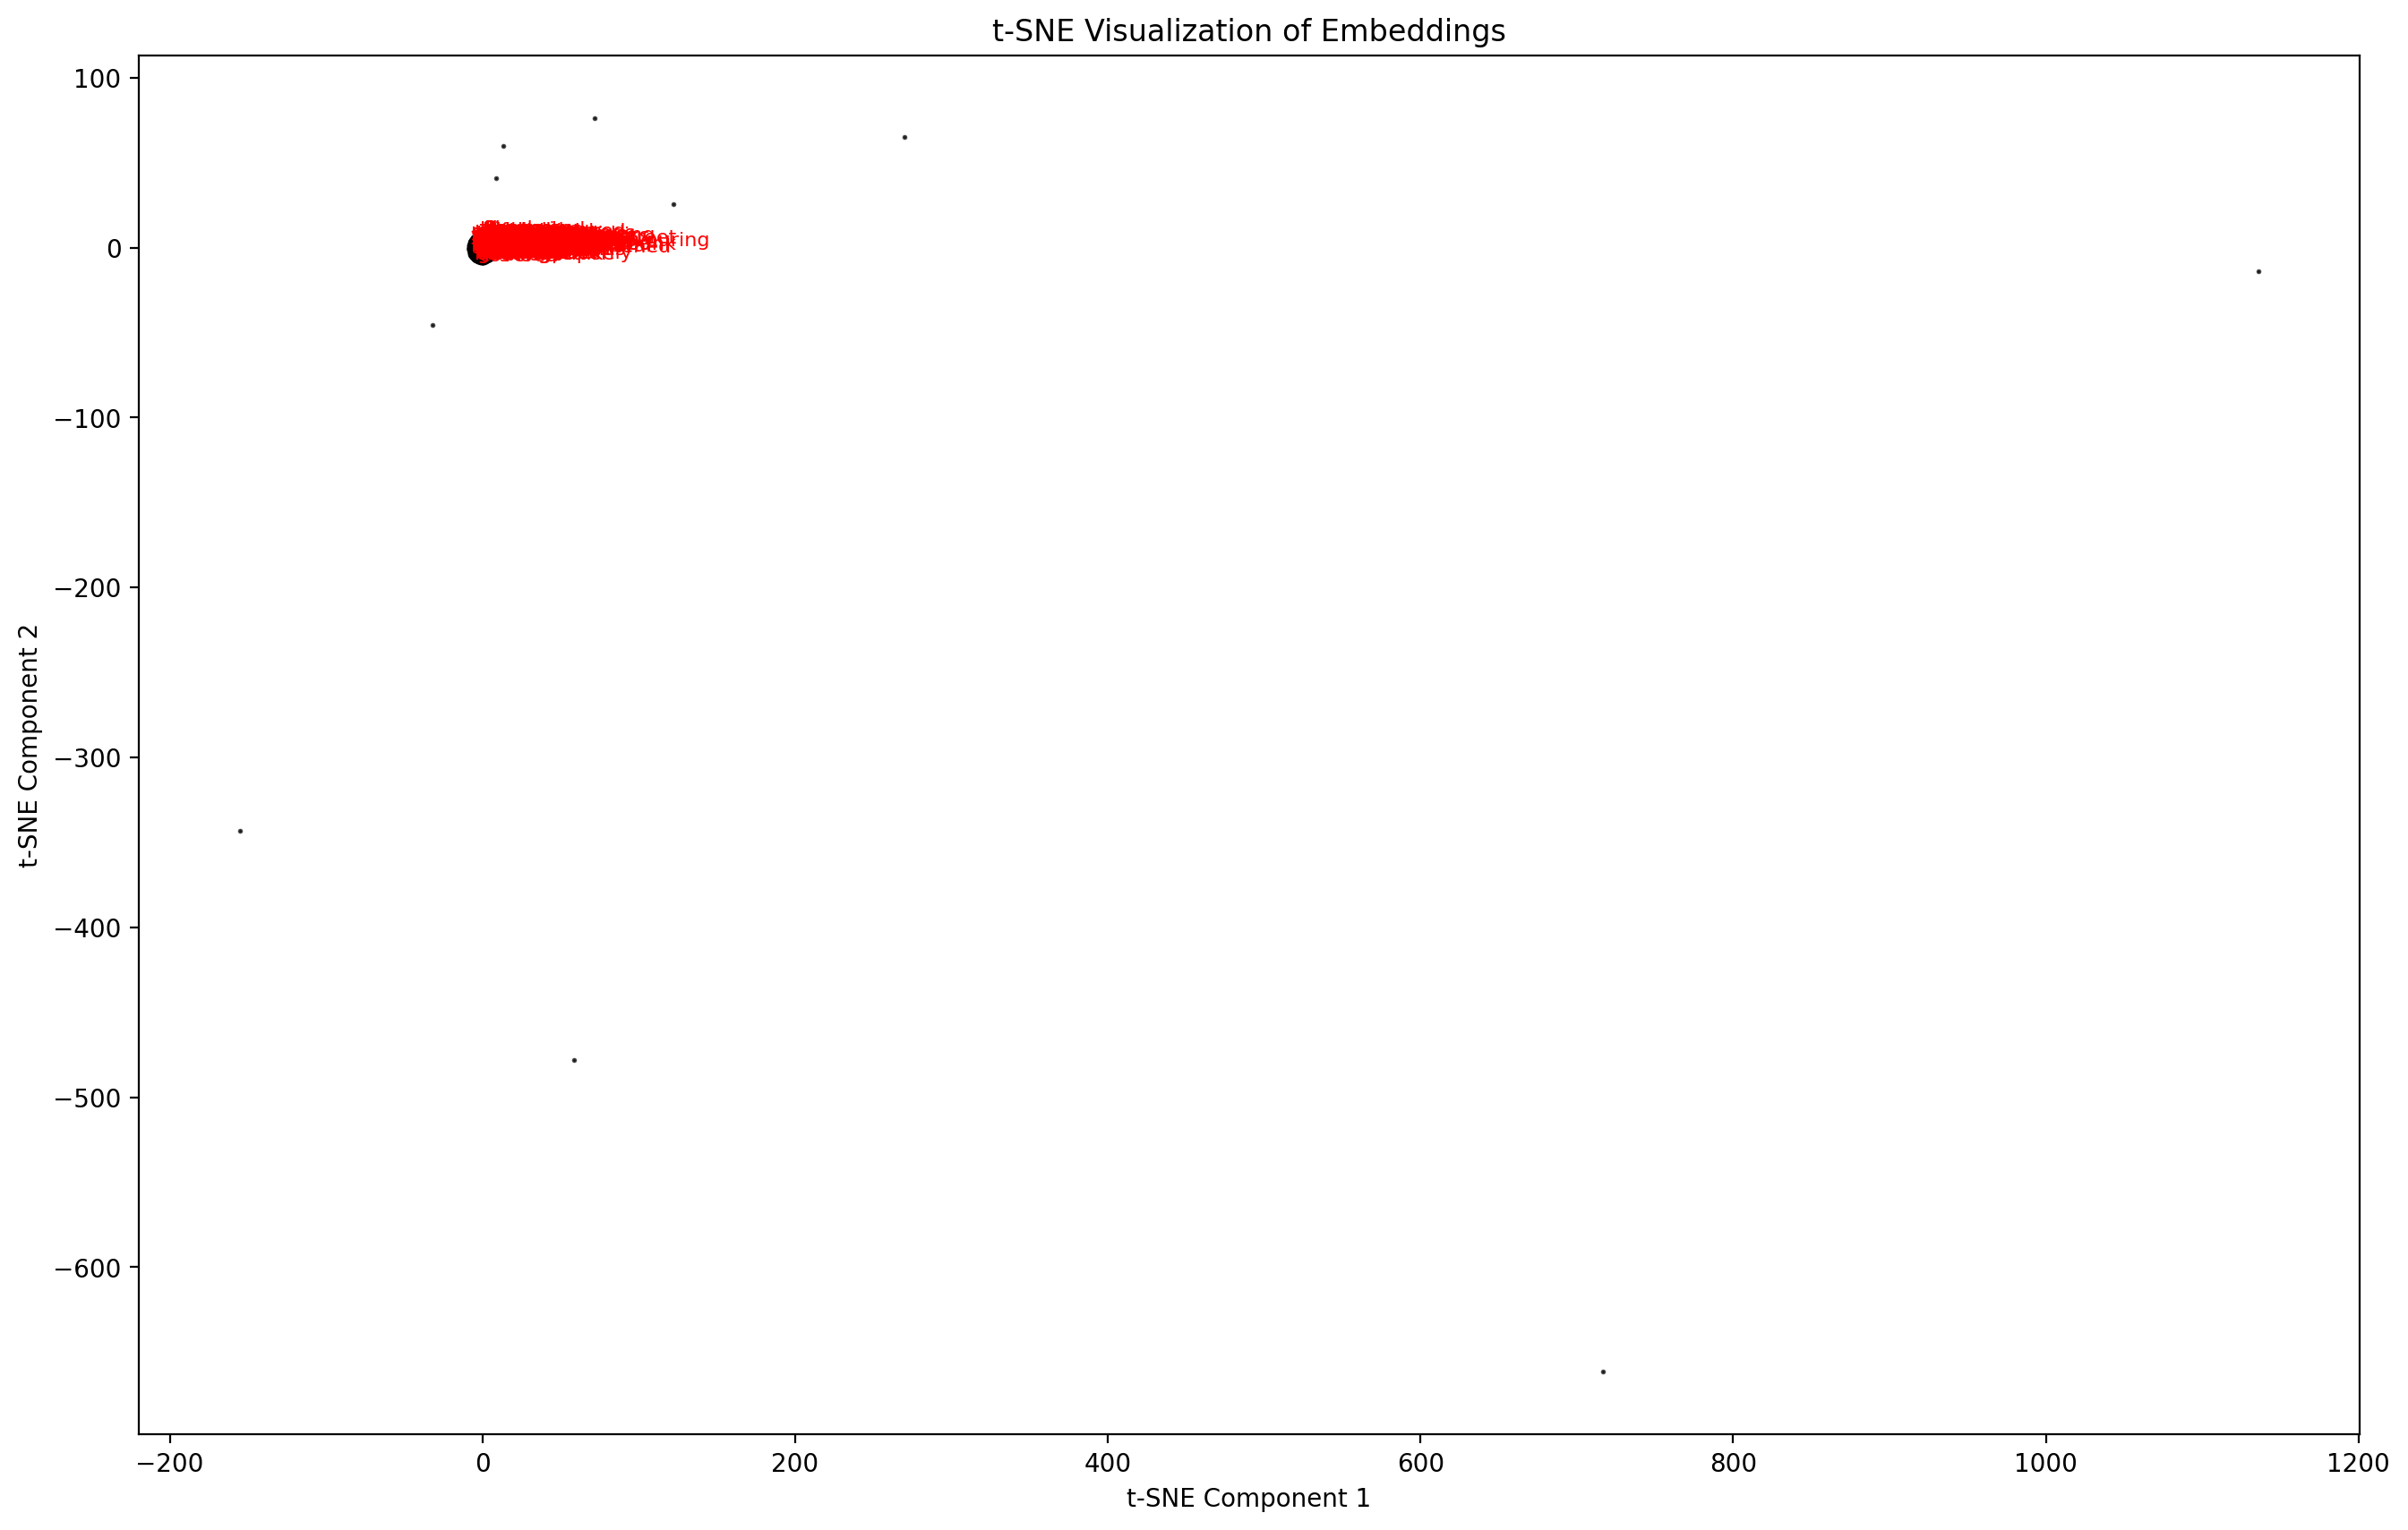

In [54]:
def plot_emb(emb, itos, ax=None, num_points_to_label=100):
    if ax is None:
        fig, ax = plt.subplots(figsize=(16, 10))
        
    # Extract the embedding weights
    emb_weights = emb.weight.detach().cpu().numpy()
    
    # Apply t-SNE to reduce dimensions
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
    emb_2d = tsne.fit_transform(emb_weights)

    # Scatter plot the t-SNE results
    ax.scatter(emb_2d[:, 0], emb_2d[:, 1], color='k', s=1, alpha=0.7)

    # Randomly select a subset of points to label
    indices = np.random.choice(len(itos), num_points_to_label, replace=False)

    # Annotate each selected point with the corresponding word
    for i in indices:
        ax.text(emb_2d[i, 0] + 0.05, emb_2d[i, 1] + 0.05, itos[i], fontsize=8, color='red')
        
    ax.set_title('t-SNE Visualization of Embeddings')
    ax.set_xlabel('t-SNE Component 1')
    ax.set_ylabel('t-SNE Component 2')
    
    return ax

# Example usage with num_points_to_label as a keyword argument
plot_emb(model.emb, itos, num_points_to_label=300)
plt.show()


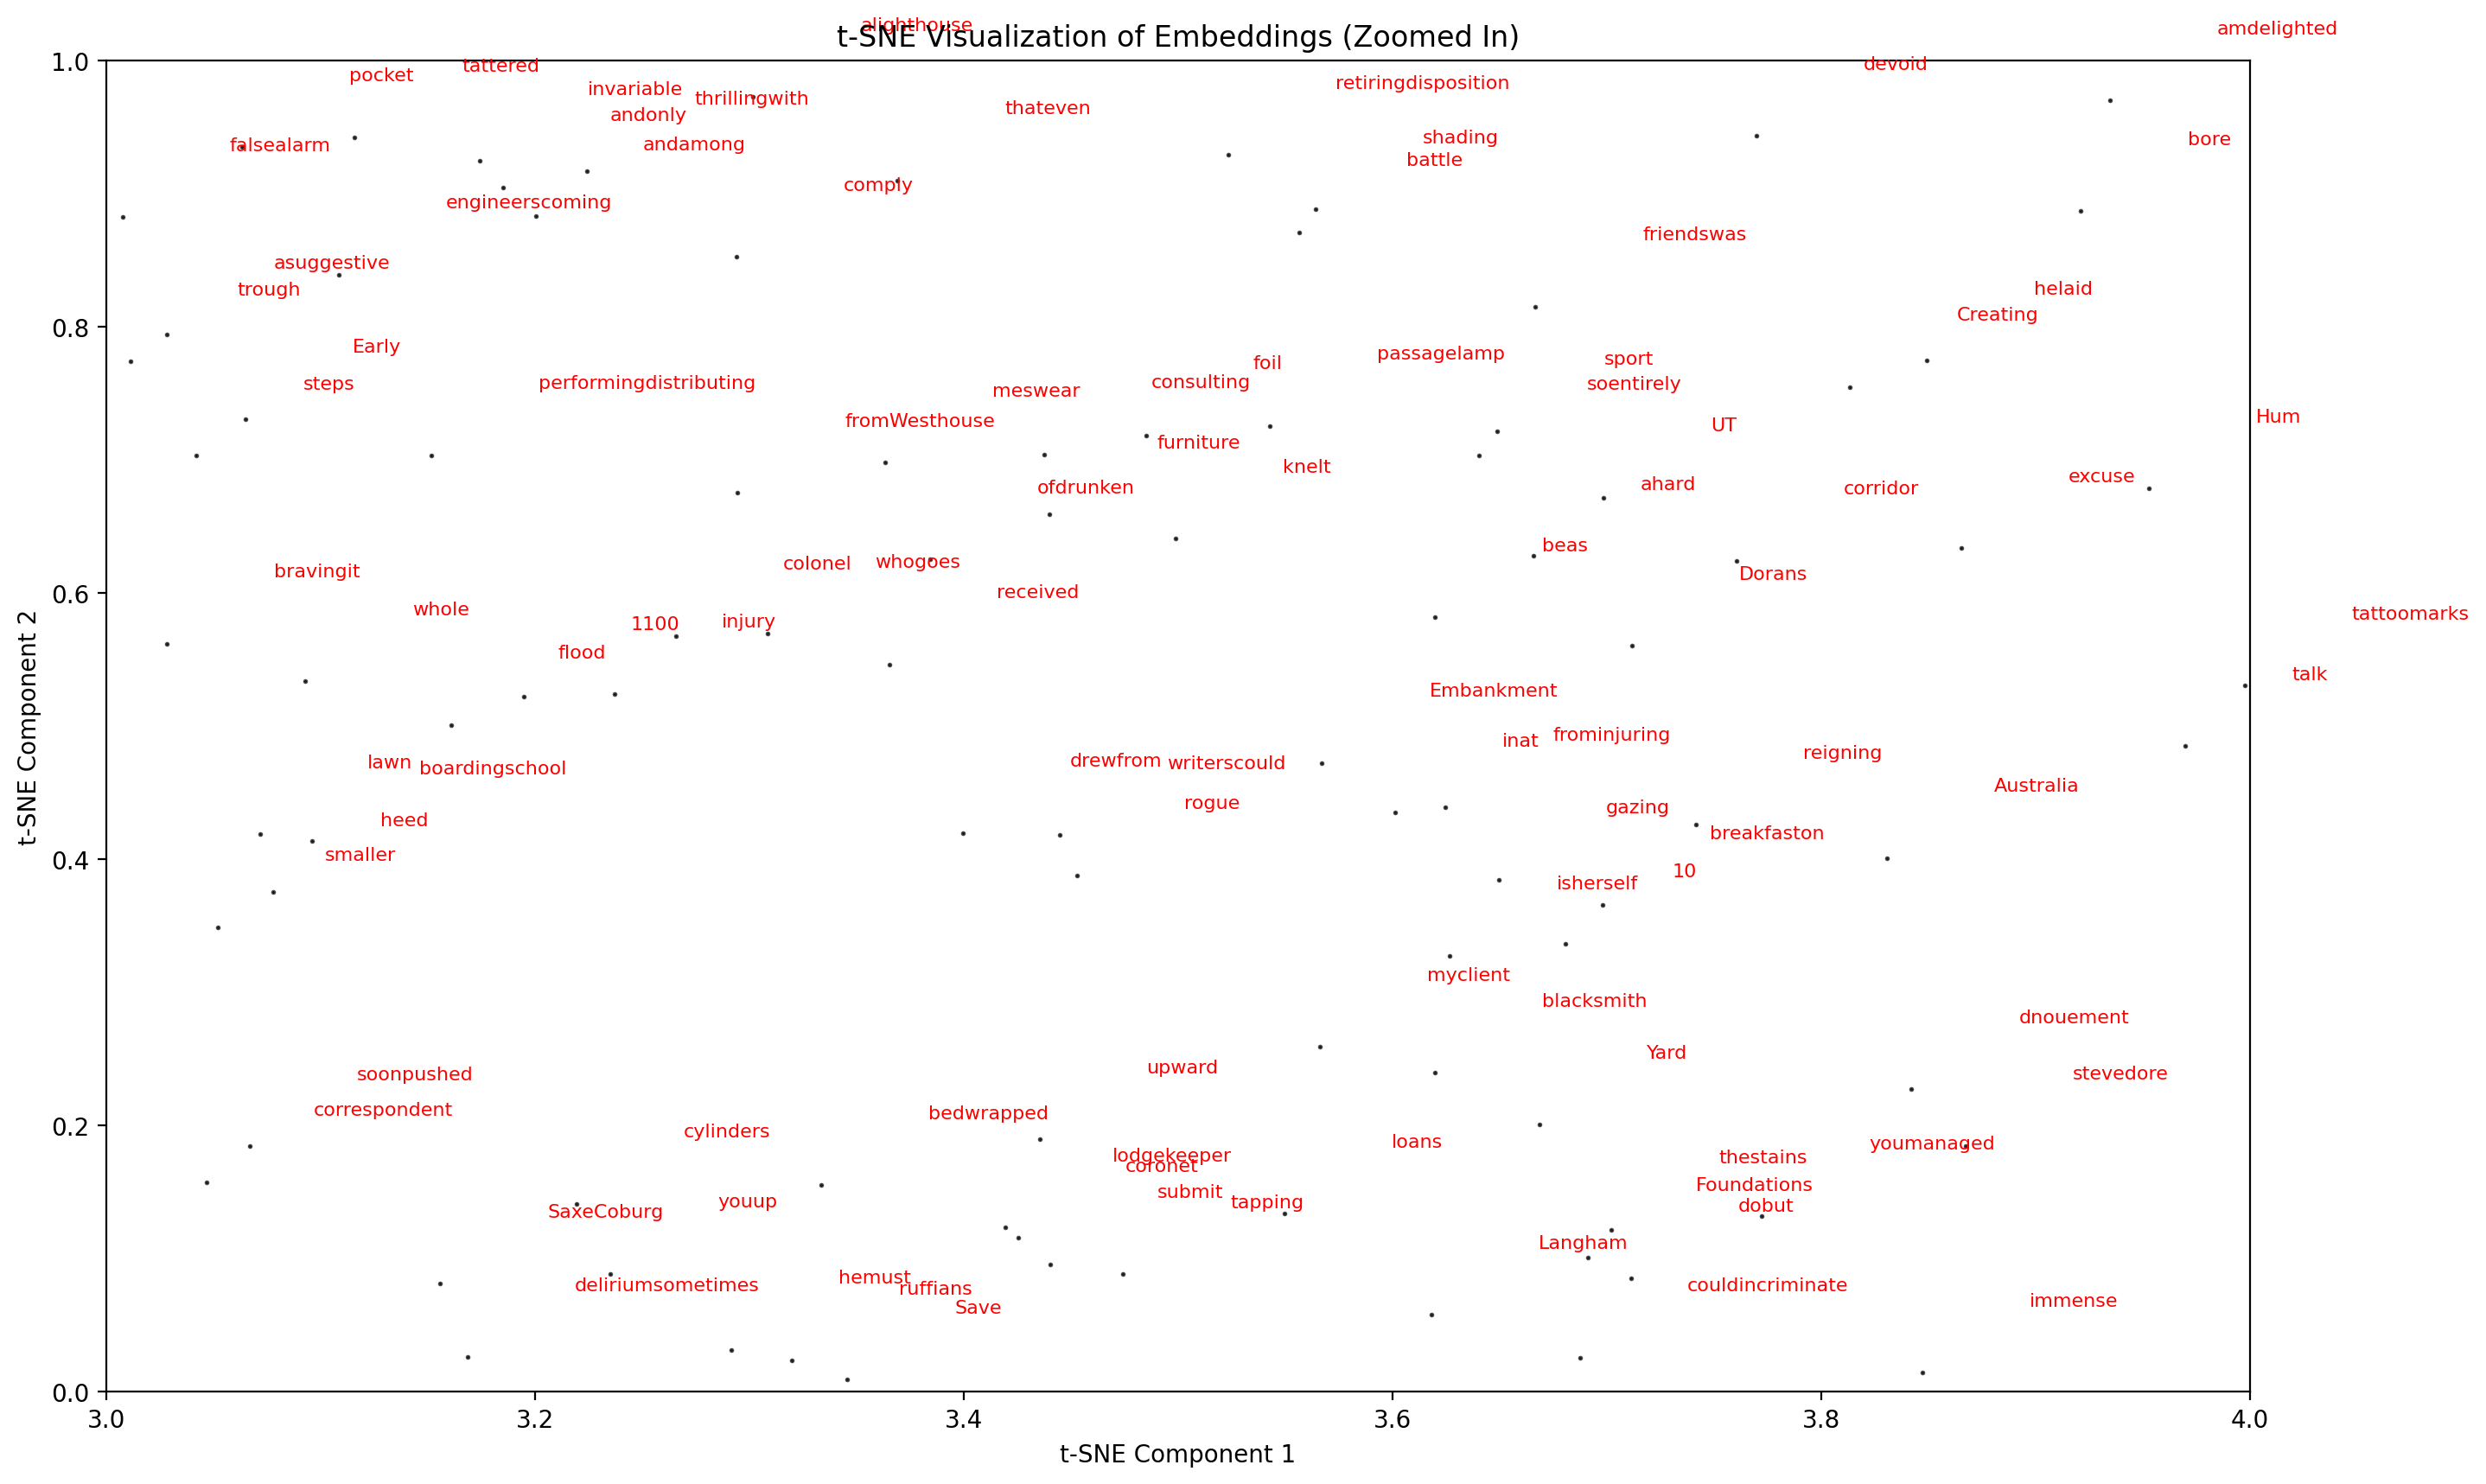

In [55]:
def plot_emb(emb, itos, ax=None, num_points_to_label=100, x_range=None, y_range=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(16, 10))
        
    # Extract the embedding weights
    emb_weights = emb.weight.detach().cpu().numpy()
    
    # Apply t-SNE to reduce dimensions
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
    emb_2d = tsne.fit_transform(emb_weights)

    # Scatter plot the t-SNE results
    ax.scatter(emb_2d[:, 0], emb_2d[:, 1], color='k', s=1, alpha=0.7)

    # If ranges are specified, filter the points within the specified region
    if x_range and y_range:
        mask = (emb_2d[:, 0] > x_range[0]) & (emb_2d[:, 0] < x_range[1]) & \
               (emb_2d[:, 1] > y_range[0]) & (emb_2d[:, 1] < y_range[1])
        indices = np.where(mask)[0]
    else:
        # Randomly select a subset of points to label if no range is specified
        indices = np.random.choice(len(itos), num_points_to_label, replace=False)

    # Annotate each selected point with the corresponding word
    for i in indices:
        ax.text(emb_2d[i, 0] + 0.05, emb_2d[i, 1] + 0.05, itos[i], fontsize=8, color='red')
        
    # Set the plot limits to zoom into the specified range
    if x_range:
        ax.set_xlim(x_range)
    if y_range:
        ax.set_ylim(y_range)
        
    ax.set_title('t-SNE Visualization of Embeddings (Zoomed In)')
    ax.set_xlabel('t-SNE Component 1')
    ax.set_ylabel('t-SNE Component 2')
    
    return ax

# Example usage with a specific range to zoom in on
plot_emb(model.emb, itos, num_points_to_label=10, x_range=(3, 4), y_range=(0, 1))
plt.show()
